In [13]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import scipy.io
import time
import torch
import torch.nn.functional as tf

In [3]:
def normalize01(x):
    x -= x.min()
    x /= x.max()
    return x

In [4]:
def imnoise(g, noise=1, sigma=0.1, theta=0.01, p_l1=0.25, p_in=0.9):
    
    # noise: 1 ... Gaussian, 2 ... S&P, 3 ... Gamma
    # sigma: standard deviation of Gaussian noise (mean=0)
    # theta: variance of Gamma noise (mean=1)
    # p_l1: fraction of outliers in S&P noise
    # p_in: fraction of missing pixels for inpainting
    
    # make a copy of g
    f = np.copy(g)
    M,N = g.shape

    if noise == 1:
        # Gaussian noise, mean = 0
        f = f + np.random.randn(M,N)*sigma
    elif noise == 2:
        # Salt and Pepper noise, a fraction of p_l1 is set either to 0 or 1
        n = np.random.rand(M,N)
        f[n <= p_l1/2] = 0.0
        f[n >= (1-p_l1/2)] = 1.0
    elif noise == 3:
        # multipliative Gamma noise, mean = 1
        k = 1/theta # ensure that mean=1
        f = f*np.random.gamma(k,theta,(M,N))
    elif noise == 4:
        # A fraction of p_in of missing pixels
        n = np.random.rand(M,N)
        f[n <= p_in] = np.nan
    return f

In [18]:
# pytorch data terms
def l22(u,f):
    return 0.5*torch.sum((u-f)**2)

def l1(u,f):
    return torch.sum(torch.abs(u-f))

def entropy(u,f):
    return torch.sum(u-f*torch.log(u))

def inpaint(u,f):
    return 0.0

# pytorch prox-operators
def prox_l22(u, f, tau):
    return (u + tau*f)/(1+tau)
    
def prox_l1(u, f, tau):
    return f + torch.clamp(torch.abs(u-f)-tau, min=0.0)*torch.sign(u-f)

def prox_entropy(u, f, tau):
    return (u-tau+torch.sqrt((u-tau)**2 + 4*tau*f))/2.0

def prox_inpaint(u, f, idx):
    return torch.where(idx, f, u)

In [24]:
def load_foe_model(model_file):

    import scipy.io

    # load student-t prior from Chen 2014
    foe = scipy.io.loadmat(model_file)

    L, K = foe.get('filters').shape
    L = np.int(np.sqrt(L))
    
    filters = np.array(foe.get('filters').reshape(L,L,K))*255
    thetas = np.array(foe.get('theta'))/255**2

    return thetas, filters

def visualize_foe_model(model_file="foe_7x7.mat"):

    import matplotlib.pyplot as plt

    thetas, filters = load_foe_model(model_file)
    _,L,K = filters.shape
    
    # visualize Foe filters and functions
    filter_norm = np.zeros(K)
    for i in range(K):
        filter_norm[i] = np.linalg.norm(filters[:,:,i])

    idx_sorted = np.argsort(filter_norm)

    dict = np.zeros((L**2, L**2))
    for i in range(L):
        for j in range(L):
            ij = i*L+j
            if ij < K:
                dict[i*L:(i+1)*L, j*L:(j+1)*L] = normalize01(filters[:,:,idx_sorted[ij]].copy())

    plt.figure(99, figsize=(5,5))
    plt.imshow(dict, cmap="gray")

    x = np.linspace(-1/2, 1/2, 100)
    fig, axs = plt.subplots(L, L, num=100, figsize=(5,5))
    for i in range(L):
        for j in range(L):
            ij = i*L+j
            if ij < K:
                axs[i, j].plot(x, thetas[idx_sorted[ij]]*np.log(1 + (filter_norm[idx_sorted[ij]]*x)**2))

    for ax in fig.get_axes():
        ax.label_outer()

In [25]:
# computes the gradient of the FoE regularizer
def compute_foe(u, lamb, thetas, filters):
    
    # Size of padding    
    pad = filters.shape[-1]//2
    
    # Perform convolution
    uf = tf.conv2d(tf.pad(u, (pad,pad,pad,pad),'reflect'), filters)
    
    # compute the value of the regularizer
    foe = lamb*torch.sum(thetas*torch.log(1.0 + uf**2))

    return foe

def foe_apgd(f, dataterm=1, lamb=1.0, maxit=1000, check=100, model_file="foe_7x7.mat", verbose=0):
    # dataterm: 1 ... l_2^2, 2 ... l_1, 3 ... entropy, 4 ... inpainting

    # check if GPU is available
    use_gpu = torch.cuda.is_available()
    print("GPU = ", use_gpu)
    dtype = torch.cuda.FloatTensor if use_gpu else torch.FloatTensor

    M,N = f.shape

    thetas, filters = load_foe_model(model_file)
    
    filters_ = torch.from_numpy(filters[np.newaxis,:,:,:]).permute(3,0,1,2).type(dtype)
    thetas_ = torch.from_numpy(thetas).view(1,-1,1,1).type(dtype)

    f_ = torch.from_numpy(f).view(1,1,M,N).type(dtype)
    u_ = torch.rand((1,1,M,N)).type(dtype)
    u_old_ = u_.clone()

    if dataterm == 4:
        idx_ = ~torch.isnan(f_)

    Lip = 2.0**20.0
    
    t0 = time.time()
    for it in range(0,maxit):
    
        # use no grad for the loop
        with torch.no_grad():
            ui_ = u_ + (it-1)/(it+2)*(u_-u_old_)

            with torch.enable_grad():             
                ui_.requires_grad_(True)
                foe_ = compute_foe(ui_, lamb, thetas_, filters_)

            # compute gradient
            grad_ = torch.autograd.grad(foe_, ui_)[0]

            
            u_old_ = u_.clone()
            for bt in range(10):
                
                u_ = ui_ - 1/Lip*grad_
                
                # proximal maps
                tau=1.0/Lip
                if dataterm == 1:
                    u_ = prox_l22(u_,f_,tau)

                if dataterm == 2:
                    u_ = prox_l1(u_,f_,tau)

                if dataterm == 3:
                    u_ = prox_entropy(u_,f_,tau)

                if dataterm == 4:
                    u_ = prox_inpaint(u_,f_,idx_)

                foe_new_ = compute_foe(u_, lamb, thetas_, filters_)
                quad_ = foe_ + torch.sum(grad_*(u_-ui_)) + Lip/2.0*torch.sum((u_-ui_)**2)

                if foe_new_ <= quad_:
                    Lip = Lip/2.0
                    break
                else:
                    Lip = Lip*2.0

            if verbose > 0:
                if it%check == check-1:

                    if dataterm == 1:
                        DT = l22(u_,f_)
                    elif dataterm == 2:
                        DT = l1(u_,f_)
                    elif dataterm == 3:
                        DT = entropy(u_,f_)
                    elif dataterm == 4:
                        DT = inpaint(u_,f_)
                        
                    E = foe_new_ + DT
                    
                    print("iter = ", it,
                          ", Lip = ", "{:3.3f}".format(Lip),
                          ", time = ", "{:3.3f}".format(time.time()-t0),
                          ", E = ", "{:3.3f}".format(E.cpu().numpy()),
                          end="\r")
                    
    return u_.cpu().squeeze()

In [ ]:
#visualize_foe_model()

In [33]:
# Load image
g = skimage.io.imread("watercastle.png")/255.0

# Add noise to the image
# noise: 1 ... Gaussian, 2 ... S&P, 3 ... Gamma, 4 ... Inpainting
noise=1
f = imnoise(g, noise=noise)

In [34]:
# Solve the TV model
# dataterm: 1 ... l_2^2, 2 ... l_1, 3 ... entropy, 4 ... inpainting

lamb = 1.0
u_foe = foe_apgd(f, dataterm=noise, lamb=lamb, maxit=100, check=10, verbose=1)

GPU =  False


<IPython.core.display.Javascript object>


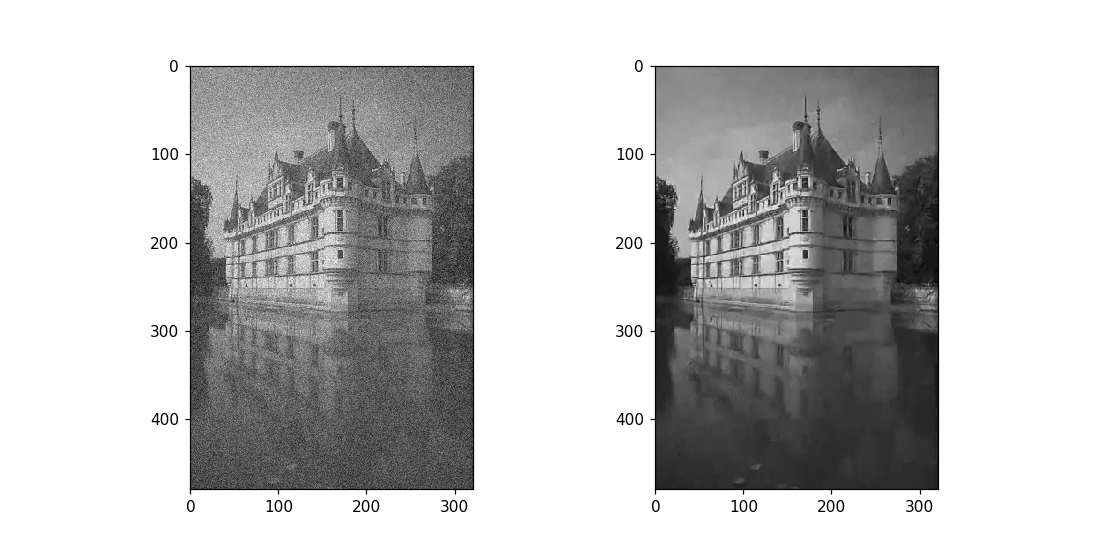

In [35]:
plt.figure(1, figsize=(10,5))

plt.subplot(121)
plt.imshow(f, cmap="gray")

plt.subplot(122)
plt.imshow(u_foe, cmap="gray")